<a href="https://colab.research.google.com/github/probml/ssm-jax/blob/main/ssm_jax/hmm/demos/casino_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HMM OF THE DISHONEST CASINO

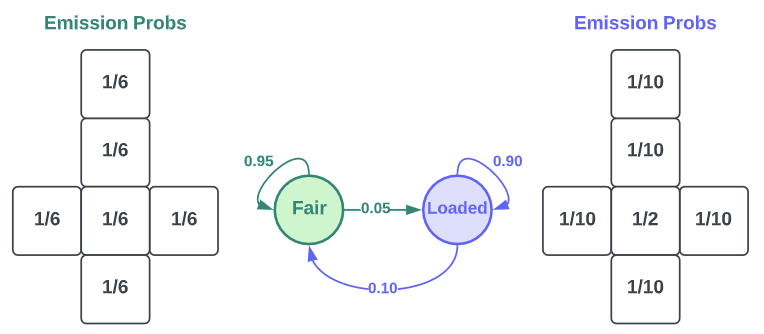

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
try:
    import ssm_jax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    import ssm_jax

     |████████████████████████████████| 140 kB 6.9 MB/s 
     |████████████████████████████████| 72 kB 620 kB/s 
     |████████████████████████████████| 272 kB 15.2 MB/s 


In [3]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import jax.numpy as jnp
import jax.random as jr
from jax import random
from jax import vmap

import optax

import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt

from ssm_jax.hmm.learning import hmm_fit_minibatch_gradient_descent
from ssm_jax.hmm.learning import hmm_fit_em
from ssm_jax.hmm.models import CategoricalHMM
from ssm_jax.hmm.models import CategoricalLogitHMM

In [7]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging
logger = logging.getLogger() 

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

## Initilization

In [5]:
def init_random_categorical_hmm(key, sizes):
    """
    Initializes the components of CategoricalHMM from normal distibution
    Parameters
    ----------
    key : array
        Random key of shape (2,) and dtype uint32
    sizes: List
      Consists of number of hidden states and observable events, respectively
    Returns
    -------
    * CategoricalHMM
    """
    initial_key, transition_key, emission_key = jr.split(key, 3)
    num_hidden_states, num_obs = sizes
    return CategoricalLogitHMM(jr.normal(initial_key, (num_hidden_states,)),
                               jr.normal(transition_key, (num_hidden_states, num_hidden_states)),
                               jr.normal(emission_key, (num_hidden_states, num_obs)))

In [8]:
key = random.PRNGKey(0)
init_key, sample_key, train_key = random.split(key, 3)

initial_probabilities = jnp.array([1, 1]) / 2

# state transition matrix
transition_matrix = jnp.array([[0.95, 0.05], [0.10, 0.90]])

# observation matrix
emission_probs = jnp.array([
    [1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],  # fair die
    [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 5 / 10]  # loaded die
])

casino = CategoricalHMM(initial_probabilities, transition_matrix, emission_probs)
sample_fn = vmap(casino.sample, in_axes=(0, None))
n, num_timesteps = 4, 5000
keys = random.split(sample_key, n)
_, emissions = sample_fn(keys, num_timesteps)

In [9]:
print(emissions.shape)

(4, 5000)


## Learning

In [10]:
sizes = emission_probs.shape
hmm = init_random_categorical_hmm(init_key, sizes)
num_iters = 400
learning_rate = 1e-2
momentum = 0.95
optimizer = optax.sgd(learning_rate=learning_rate, momentum=momentum)

### Full-Batch Gradient Descent

In [11]:
batch_size = n
hmm_fb, losses_fbgd = hmm_fit_minibatch_gradient_descent(hmm, emissions, optimizer, batch_size, num_iters,
                                                             train_key)

### Mini-Batch Gradient Descent

In [12]:
batch_size = 2
hmm_mb, losses_mbgd = hmm_fit_minibatch_gradient_descent(hmm, emissions, optimizer, batch_size, num_iters,
                                                             train_key)

### Stochastic Gradient Descent

In [13]:
batch_size = 1
hmm_sgd, losses_sgd = hmm_fit_minibatch_gradient_descent(hmm, emissions, optimizer, batch_size, num_iters,
                                                             train_key)

### Expectation-Maximization

In [14]:
hmm_em, losses_em = hmm_fit_em(hmm, emissions, num_iters=20)
losses_em = np.array(losses_em) * -1

  0%|          | 0/20 [00:00<?, ?it/s]

## Results

In [15]:
def hmm_plot_graphviz(trans_mat, obs_mat, states=[], observations=[]):
    """
    Visualizes HMM transition matrix and observation matrix using graphhiz.
    Parameters
    ----------
    trans_mat, obs_mat, init_dist: arrays
    states: List(num_hidden)
        Names of hidden states
    observations: List(num_obs)
        Names of observable events
    Returns
    -------
    dot object, that can be displayed in colab
    """

    n_states, n_obs = obs_mat.shape

    dot = Digraph(comment='HMM')
    if not states:
        states = [f'State {i + 1}' for i in range(n_states)]
    if not observations:
        observations = [f'Obs {i + 1}' for i in range(n_obs)]

    # Creates hidden state nodes
    for i, name in enumerate(states):
        table = [f'<TR><TD>{observations[j]}</TD><TD>{"%.2f" % prob}</TD></TR>' for j, prob in enumerate(obs_mat[i])]
        label = f'''<<TABLE><TR><TD BGCOLOR="lightblue" COLSPAN="2">{name}</TD></TR>{''.join(table)}</TABLE>>'''
        dot.node(f's{i}', label=label)

    # Writes transition probabilities
    for i in range(n_states):
        for j in range(n_states):
            dot.edge(f's{i}', f's{j}', label=str('%.2f' % trans_mat[i, j]))
    dot.attr(rankdir='LR')
    # dot.render(file_name, view=True)
    return dot

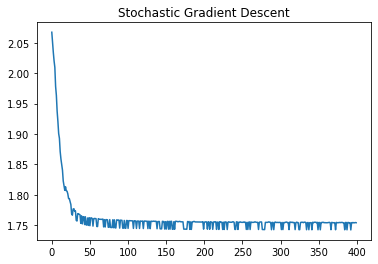

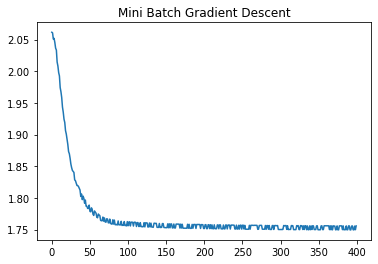

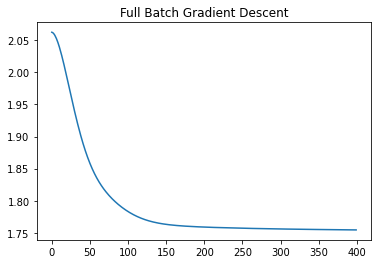

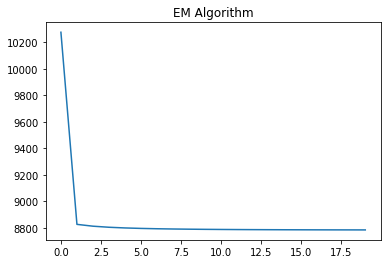

In [16]:
losses = [losses_sgd, losses_mbgd, losses_fbgd, losses_em]

titles = ["Stochastic Gradient Descent",
          "Mini Batch Gradient Descent",
          "Full Batch Gradient Descent",
          "EM Algorithm"]
          
dict_figures = {}

for loss, title in zip(losses, titles):
    filename = title.replace(" ", "_").lower()
    fig, ax = plt.subplots()
    ax.plot(loss)
    ax.set_title(f"{title}")
    dict_figures[filename] = fig
    plt.savefig(f"{filename}.png", dpi=300)

plt.show()

In [21]:
dotfile = hmm_plot_graphviz(hmm_fb.transition_matrix, hmm_fb.emission_probs)

dotfile.render("hmm-casino-fb-dot")

'hmm-casino-fb-dot.pdf'

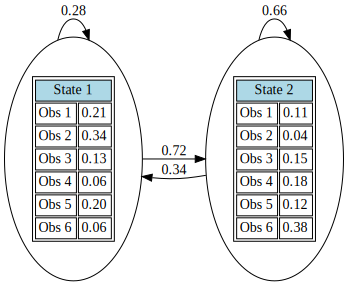

In [22]:
dotfile

In [19]:
dotfile = hmm_plot_graphviz(hmm_em.transition_matrix, hmm_em.emission_probs)
dotfile.render("hmm-casino-em-dot")

'hmm-casino-em-dot.pdf'

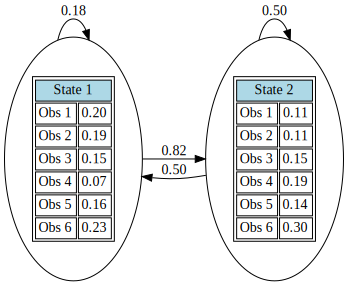

In [20]:
dotfile